# Final Exam and Presentation

Task

Find together in groups of 2 persons
Select a dataset of interest in the area for healthcare for your supervised or unsupervised study. Use open dataset repositories such as UCI Machine Learning Repository or Kaggle. 
Define your research question.
Create a directory in your Git repository (GitHub) termed "AMLHC-final-exam"
Implement your knowledge discovery workflow including preprocessing, supervised- or unsupervised learning using code versioning (git).
Create a final evaluation report where you interpret your findings and discuss your research question. You can either create a separate report using Word/LaTeX or extend your notebook using Markdown/sweave. 
Regularly update your progress using git

In [18]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt

## Basic Data Exploration

ich nutze pandas um den Datensatz besser kennenzulernen und zu bearbeiten 

In [4]:
df = pd.read_csv("stroke-data.csv")
df.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


The results show 7 numbers for each column in your original dataset. The first number, the count, shows how many rows have non-missing values
Result BMI hat fehlende Werte also ist der nächste Schritt die bereinigung des Datensatzes 

In [ ]:
# dropna drops missing values (think of na as "not available")
df = df.dropna(axis=0)
df.drop(columns=["id"], inplace=True)

In [26]:
df.describe()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,4908.000000,4457.0,4665.0,4341.000000,4798.000000,4908.000000
mean,42.868810,0.0,0.0,91.452820,28.314819,0.042584
std,22.556128,0.0,0.0,22.673642,6.841431,0.201937
min,0.080000,0.0,0.0,55.120000,10.300000,0.000000
25%,25.000000,0.0,0.0,75.050000,23.425000,0.000000
50%,44.000000,0.0,0.0,87.980000,27.900000,0.000000
75%,60.000000,0.0,0.0,104.000000,32.600000,0.000000
max,82.000000,0.0,0.0,168.150000,47.500000,1.000000


supervised learning 

In [ ]:
df = df[df["gender"] != "Other"]
df = pd.get_dummies(df, columns=["gender"], drop_first=True)

/var/folders/h4/rxs_f2t56ng4372r52py0g0h0000gn/T/ipykernel_30520/2815623142.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["bmi"].fillna(df["bmi"].median(), inplace=True)


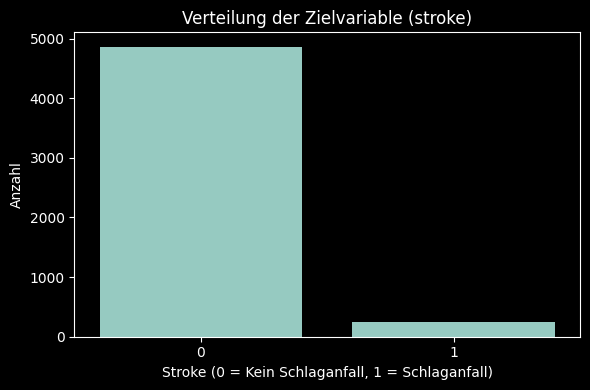

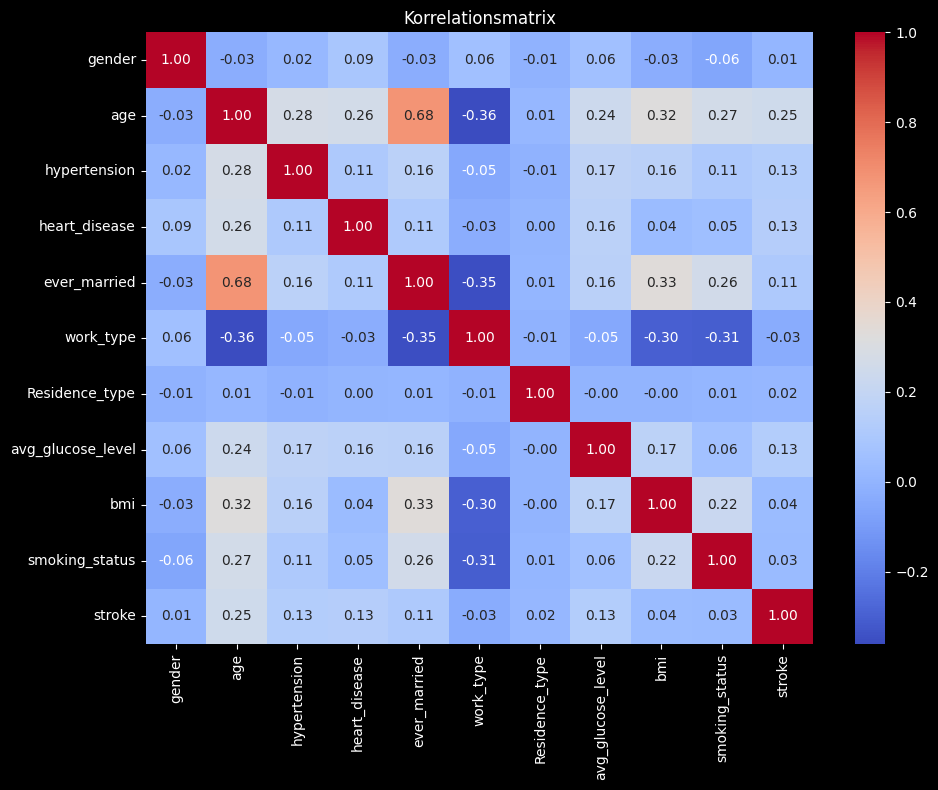

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

# === 1. Daten laden ===
df = pd.read_csv("stroke-data.csv")

# === 2. Irrelevante Spalte entfernen ===
df = df.drop(columns=["id"])

# === 3. Fehlende Werte behandeln ===
df["bmi"].fillna(df["bmi"].median(), inplace=True)

# === 4. Kategoriale Variablen codieren ===
categorical_cols = df.select_dtypes(include="object").columns
label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# === 5. Zielvariable untersuchen ===
plt.figure(figsize=(6, 4))
sns.countplot(x="stroke", data=df)
plt.title("Verteilung der Zielvariable (stroke)")
plt.xlabel("Stroke (0 = Kein Schlaganfall, 1 = Schlaganfall)")
plt.ylabel("Anzahl")
plt.tight_layout()
plt.show()

# === 6. Korrelationsmatrix anzeigen ===
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Korrelationsmatrix")
plt.tight_layout()
plt.show()

# === 7. Optional: vorbereiteten Datensatz speichern ===
df.to_csv("stroke-data-preprocessed.csv", index=False)

In [32]:
# alle Zeilen selektieren vom Typ number also nur die numerischen Werte

numeric_cols = df.select_dtypes(include=['number']).columns
#die detection
Q1 = df[numeric_cols].quantile(0.25) # 25% Quantil
Q3 = df[numeric_cols].quantile(0.75) # 75% Quantil
IQR = Q3 - Q1 # Interquartilbereich

#defineren der Außreißer -> Werte die außerhalb des Interquartilbereichs liegen

lower_bound = Q1 - 1.5 * IQR 
upper_bound = Q3 + 1.5 * IQR

#definerten Außenseiter mit NA ersetzen
outliers = ((df[numeric_cols] < lower_bound) | (df[numeric_cols] > upper_bound))
df[numeric_cols] = df[numeric_cols].mask(outliers)
# true wenn ein Wert ein Außenseiter ist - False wenn er im Interquartilbereich liegt

print("\nRandwerte die mit Na ergänz werden.\nAnzahl fehlender Werte:")
print(df.isnull().sum())

# leere Zeilen löschen 
df_clean = df.dropna()
print("\nDaten ohne Außreißer (after removing outliers):", df_clean.shape)


Randwerte die mit Na ergänz werden.
Anzahl fehlender Werte:
gender                 0
age                    0
hypertension         498
heart_disease        276
ever_married           0
work_type            657
Residence_type         0
avg_glucose_level    750
bmi                  147
smoking_status         0
stroke               249
dtype: int64

Daten ohne Außreißer (after removing outliers): (3248, 11)


Wichtig: die Außreißer können Modelle verzerren - mann sollte aber die 0 in manchen Variablen prüfen

In [35]:
print("\nSummary Statistics (After Cleaning):\n")
print(df_clean.describe())


Summary Statistics (After Cleaning):

            gender          age  hypertension  heart_disease  ever_married  \
count  3248.000000  3248.000000        3248.0         3248.0   3248.000000   
mean      0.404249    36.106663           0.0            0.0      0.552956   
std       0.491449    21.984090           0.0            0.0      0.497264   
min       0.000000     0.080000           0.0            0.0      0.000000   
25%       0.000000    18.000000           0.0            0.0      0.000000   
50%       0.000000    35.000000           0.0            0.0      1.000000   
75%       1.000000    53.000000           0.0            0.0      1.000000   
max       2.000000    82.000000           0.0            0.0      1.000000   

         work_type  Residence_type  avg_glucose_level          bmi  \
count  3248.000000     3248.000000        3248.000000  3248.000000   
mean      2.543411        0.507697          89.791001    27.103387   
std       0.814460        0.500018          20.2

In [36]:
# Definieren Merkmale und Zielvariable X ist dann zum "Füttern" des Modells und y ist das Ziel, das vorhergesagt werden soll
X = df_clean.drop('stroke', axis=1)
y = df_clean['stroke']

# Min und Max Skalierung
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Chi2 test
chi2_scores, p_values = chi2(X_scaled, y)

# raning der Features erstellen, die auf den Chi2-Scores basieren
feature_ranking = pd.DataFrame({
    'Feature': X.columns,
    'Chi2_Score': chi2_scores,
    'P_Value': p_values
}).sort_values(by='Chi2_Score', ascending=False)

print("\nChi-squared Feature Ranking:\n", feature_ranking)


Chi-squared Feature Ranking:
              Feature  Chi2_Score  P_Value
0             gender         NaN      NaN
1                age         NaN      NaN
2       hypertension         NaN      NaN
3      heart_disease         NaN      NaN
4       ever_married         NaN      NaN
5          work_type         NaN      NaN
6     Residence_type         NaN      NaN
7  avg_glucose_level         NaN      NaN
8                bmi         NaN      NaN
9     smoking_status         NaN      NaN


In [37]:
X_chi2 = X[['gender', 'hypertension', 'heart_disease', 'ever_married', 'Residence_type']]  # nur diskrete

chi2_scores, p_values = chi2(X_chi2, y)

feature_ranking = pd.DataFrame({
    'Feature': X_chi2.columns,
    'Chi2_Score': chi2_scores,
    'P_Value': p_values
}).sort_values(by='Chi2_Score', ascending=False)

print(feature_ranking)

          Feature  Chi2_Score  P_Value
0          gender         NaN      NaN
1    hypertension         NaN      NaN
2   heart_disease         NaN      NaN
3    ever_married         NaN      NaN
4  Residence_type         NaN      NaN


In [38]:
from sklearn.feature_selection import chi2
import pandas as pd

# Nur diskrete Merkmale auswählen
X = df_clean[['gender', 'hypertension', 'heart_disease', 'ever_married', 'Residence_type']].copy()
y = df_clean['stroke']

# Kategoriale Variablen in numerische Codes umwandeln (falls nötig)
for col in X.select_dtypes(include='object').columns:
    X[col] = X[col].astype('category').cat.codes

# Chi²-Test
chi2_scores, p_values = chi2(X, y)

# Ranking
feature_ranking = pd.DataFrame({
    'Feature': X.columns,
    'Chi2_Score': chi2_scores,
    'P_Value': p_values
}).sort_values(by='Chi2_Score', ascending=False)

print(feature_ranking)

          Feature  Chi2_Score  P_Value
0          gender         NaN      NaN
1    hypertension         NaN      NaN
2   heart_disease         NaN      NaN
3    ever_married         NaN      NaN
4  Residence_type         NaN      NaN
